# Predicting the Norwegian Parliament Election 2025

* A model using bayesian statistics to predict the outcome of the Parliement election.

### Notes
* 169 mandates, 150 direkte, 19 utgjevningsmandater, en fra hvert valg distrikt

In [324]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
import re
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', None)

### Constants

In [325]:
valgdistrikt=np.array(["Østfold", "Akershus", "Oslo", "Hedemark", "Oppland", "Buskerud", "Vestfold","Telemark", "Aust-Agder", "Vest-Agder", "Rogaland","Hordaland","Sogn og Fjordane","Møre og Romsdal","Sør-Trøndelag","Nord-Trøndelag","Nordland","Troms", "Finnmark"])
partier= np.array(['Ap', 'Høyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rødt', 'Andre'])

In [326]:
# Latest local polling data
urls=["https://www.pollofpolls.no/?cmd=Stortinget&fylke=1",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=2",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=3",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=4",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=5",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=6",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=7",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=8",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=9",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=10",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=11",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=12", #hordaland
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=14", #sogn
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=15",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=16",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=17",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=18",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=19",
      "https://www.pollofpolls.no/?cmd=Stortinget&fylke=20",
      ]

In [327]:
# 2021 Election data urls
urls_valg = ['https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=1',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=2',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=3',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=4',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=5',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=6',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=7',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=8',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=9',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=10',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=11',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=12', # 13 er ikke med
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=14',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=15',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=16',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=17',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=18',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=19',
             'https://www.pollofpolls.no/?cmd=Stortinget&do=visvalg&valg=2021&id=20']

### Data scraping Polling Data
Extracting the local polling data in each the 19 election districts from https://www.pollofpolls.no. For each Election district the polling data concists of the distribtuion of votes (%) between the parties Ap, Høyre, Frp, SV, Sp, KrF, Venstre, MDG, Rødt, Andre. 

In [328]:
def extract_local_polling_data(url_list):
    valgdistrikt=np.array(["Østfold", "Akershus", "Oslo", "Hedemark", "Oppland", "Buskerud", "Vestfold","Telemark", "Aust-Agder", "Vest-Agder", "Rogaland","Hordaland","Sogn og Fjordane","Møre og Romsdal","Sør-Trøndelag","Nord-Trøndelag","Nordland","Troms", "Finnmark"])   
    partier= np.array(['Ap', 'Høyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rødt', 'Andre'])
    df_new = pd.DataFrame({"Valgdistrikt": np.repeat(valgdistrikt, 10, axis=0), "Partier": np.tile(partier,19),"Poll-dato":np.nan})

    prosent_lister=np.array([])
    dato_lister=np.array([])

    for url in urls:
        page = urlopen(url)
        html_bytes = page.read()
        html = html_bytes.decode("utf-8")
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table') #find all tables
        rows = table.find_all('tr') # find each row
        prosenter=[]
        for row in rows:
            cells = row.find_all(['th', 'td'])  # Find both header and data cells
            cell_texts = [cell.get_text(strip=True) for cell in cells]

            if cell_texts[0]=="Siste lokale målings":
                for i in range(1,11): #number of parties
                    tekst = cell_texts[i]
                    index = tekst.find(' (')
                    tall_string_format = tekst[0:index]
                    tall_string_med_komma = tall_string_format.replace(',','.')
                    tall = float(tall_string_med_komma)
                    prosenter.append(tall)
        prosent_lister=np.append(prosent_lister,prosenter)
        # add date to poll
        for li in soup.find_all('li'):
            sup_tag = li.find('sup')
            if sup_tag and sup_tag.text=='s':
                text = li.get_text()
                index1=text.find('(')
                index2=text.find(')')
                date=text[index1+1:index2]
                break
        dato_lister=np.append(dato_lister,[date for i in range(0,10)])


    df_new['Prosent-oppsluttning'] = prosent_lister
    df_new['Poll-dato'] = dato_lister

    return df_new
                

### Data scraping 2021 Election results
Extracting the local polling data in each the 19 election districts from https://www.pollofpolls.no. For each Election district the polling data concists of the distribtuion of votes (%) between the parties Ap, Høyre, Frp, SV, Sp, KrF, Venstre, MDG, Rødt, Andre. 

In [329]:
def extract_2021_election(url_list):
    valgdistrikt=np.array(["Østfold", "Akershus", "Oslo", "Hedemark", "Oppland", "Buskerud", "Vestfold","Telemark", "Aust-Agder", "Vest-Agder", "Rogaland","Hordaland","Sogn og Fjordane","Møre og Romsdal","Sør-Trøndelag","Nord-Trøndelag","Nordland","Troms", "Finnmark"])   
    partier= np.array(['Ap', 'Høyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rødt', 'Andre'])
    df_new = pd.DataFrame({"Valgdistrikt": np.repeat(valgdistrikt, 10, axis=0), "Partier": np.tile(partier,19)})
    df_list = []

    for url in url_list:
        page = urlopen(url)
        html_bytes = page.read()
        html = html_bytes.decode("utf-8")
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.find('table') #find all tables
        rows = table.find_all('tr') # find each row
        rows2 = table.find_all('td')
        liste = []
        for row in rows2:
            tall = row.text
            tall = tall.replace(" ","") # remove blank space 1000 separator
            tall = tall.replace(",",".") 
            liste.append(float(tall))
        df = pd.DataFrame()
        for i in range(0,len(liste),8):
            new_row = {'Forhånd': liste[i],
                    'Valgting': liste[i+1],
                    'Stemmer': liste[i+2],
                    'Endr-sum': liste[i+3],
                    'Fordeling': liste[i+4],
                    'Endr-for': liste[i+5],
                    'Mandat': liste[i+6],
                    'Endr-Mandat': liste[i+7]}
            df = df._append(new_row,ignore_index = True)
        df_list.append(df)

    df_conc_ver = pd.concat(df_list, ignore_index=True, axis=0)
    df_concat_final = pd.concat([df_new, df_conc_ver], axis=1)

    return df_concat_final

    

In [330]:
df_election = extract_2021_election(urls_valg)
df_poll=extract_local_polling_data(urls)

# save the data
df_poll.to_csv('data\polldata_nov24.csv', index=False)
df_election.to_csv('data\electiondata_nov24.csv', index=False)  

In [331]:
df_poll = pd.read_csv('data\polldata_nov24.csv')
df_election = pd.read_csv('data\electiondata_nov24.csv')

df_election['Fordeling'] = 0.01*df_election['Fordeling']
df_poll['Prosent-oppsluttning'] = 0.01*df_poll['Prosent-oppsluttning']
df_poll["Poll-dato"] = pd.to_datetime(df_poll["Poll-dato"],format='mixed')




df_stemmer = pd.DataFrame({"tot_stemmer_per_distrikt": np.repeat(df_election.groupby(['Valgdistrikt'],sort=False).sum()['Stemmer'].values, 10, axis=0)})
df_joined =pd.concat([df_poll['Valgdistrikt'], df_poll['Partier'], df_poll['Prosent-oppsluttning'],df_poll['Poll-dato'],df_election['Stemmer'],df_election['Fordeling'],df_stemmer["tot_stemmer_per_distrikt"] ],
                      axis=1,
                      keys=['Valgdistrikt', 'Partier','Fordeling-poll','Poll-dato','Stemmer-valg','Fordeling-valg', 'Total-stemmer'])


In [332]:
df_joined.head(10)

,Valgdistrikt,Partier,Fordeling-poll,Poll-dato,Stemmer-valg,Fordeling-valg,Total-stemmer
0,Østfold,Ap,0.275,2021-10-09,49345.0,0.305,161896.0
1,Østfold,Høyre,0.178,2021-10-09,30211.0,0.187,161896.0
2,Østfold,Frp,0.159,2021-10-09,20527.0,0.127,161896.0
3,Østfold,SV,0.077,2021-10-09,9840.0,0.061,161896.0
4,Østfold,Sp,0.129,2021-10-09,22849.0,0.141,161896.0
5,Østfold,KrF,0.028,2021-10-09,5414.0,0.033,161896.0
6,Østfold,Venstre,0.031,2021-10-09,4771.0,0.029,161896.0
7,Østfold,MDG,0.044,2021-10-09,4782.0,0.030,161896.0
8,Østfold,Rødt,0.050,2021-10-09,7418.0,0.046,161896.0
9,Østfold,Andre,0.031,2021-10-09,6739.0,0.042,161896.0


In [333]:
df_election.head(10)

,Valgdistrikt,Partier,Forhånd,Valgting,Stemmer,Endr-sum,Fordeling,Endr-for,Mandat,Endr-Mandat
0,Østfold,Ap,24817.0,24528.0,49345.0,-2200.0,0.305,-1.6,3.0,0.0
1,Østfold,Høyre,15598.0,14613.0,30211.0,-8053.0,0.187,-5.1,2.0,0.0
2,Østfold,Frp,9329.0,11198.0,20527.0,-7654.0,0.127,-4.8,1.0,-1.0
3,Østfold,SV,5525.0,4315.0,9840.0,2804.0,0.061,1.7,1.0,0.0
4,Østfold,Sp,10082.0,12767.0,22849.0,8906.0,0.141,5.4,2.0,1.0
5,Østfold,KrF,2576.0,2838.0,5414.0,-1397.0,0.033,-0.9,0.0,0.0
6,Østfold,Venstre,2408.0,2363.0,4771.0,893.0,0.029,0.5,0.0,0.0
7,Østfold,MDG,2974.0,1808.0,4782.0,590.0,0.030,0.3,0.0,0.0
8,Østfold,Rødt,4258.0,3160.0,7418.0,3983.0,0.046,2.4,0.0,0.0
9,Østfold,Andre,3675.0,3064.0,6739.0,3204.0,0.042,2.0,0.0,0.0


### Plotting the data

In [334]:
def plot_data():
    df_plot = df_poll[['Valgdistrikt','Partier','Poll-dato']]
    df_plot["Endring"] = 100*(df_poll["Prosent-oppsluttning"]-df_election["Fordeling"])   #abs(df_poll["Prosent-oppsluttning"]-df_election["Fordeling"])

    # Group by election district
    districts = df_plot["Valgdistrikt"].unique()

    # Setup subplot grid
    num_districts = len(districts)
    cols = 3  # Number of columns in the subplot grid
    rows = -(-num_districts // cols)  # Calculate rows (ceil division)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 15), constrained_layout=True)
    recent = pd.to_datetime("2024-01-01 00:00:00") # Just to categorize plots based on how old the polling data is.

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    for i, district in enumerate(districts):
        district_data = df_plot[df_plot["Valgdistrikt"] == district]
        ax = axes[i]

        if district_data['Poll-dato'].iloc[0]>=recent:
            colorchoice = 'skyblue' # color plots with new poll data blue
        else:
            colorchoice = 'lightcoral' # or this color of old polling data.

        ax.bar(district_data["Partier"], district_data["Endring"], color=colorchoice) #'skyblue'
        ax.set_title(district+ " " + str(district_data['Poll-dato'].iloc[0]))                             #Endre denne så vi ikke får klokkeslett med
        ax.set_ylim(-25, 25)
        ax.set_xticks(range(len(district_data["Partier"])))
        ax.set_xticklabels(district_data["Partier"], rotation=45)
        ax.set_ylabel("Vote %")
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Endring i partioppsluttning fra valget i 2021 til nyeste poll", fontsize=16)
    plt.show()


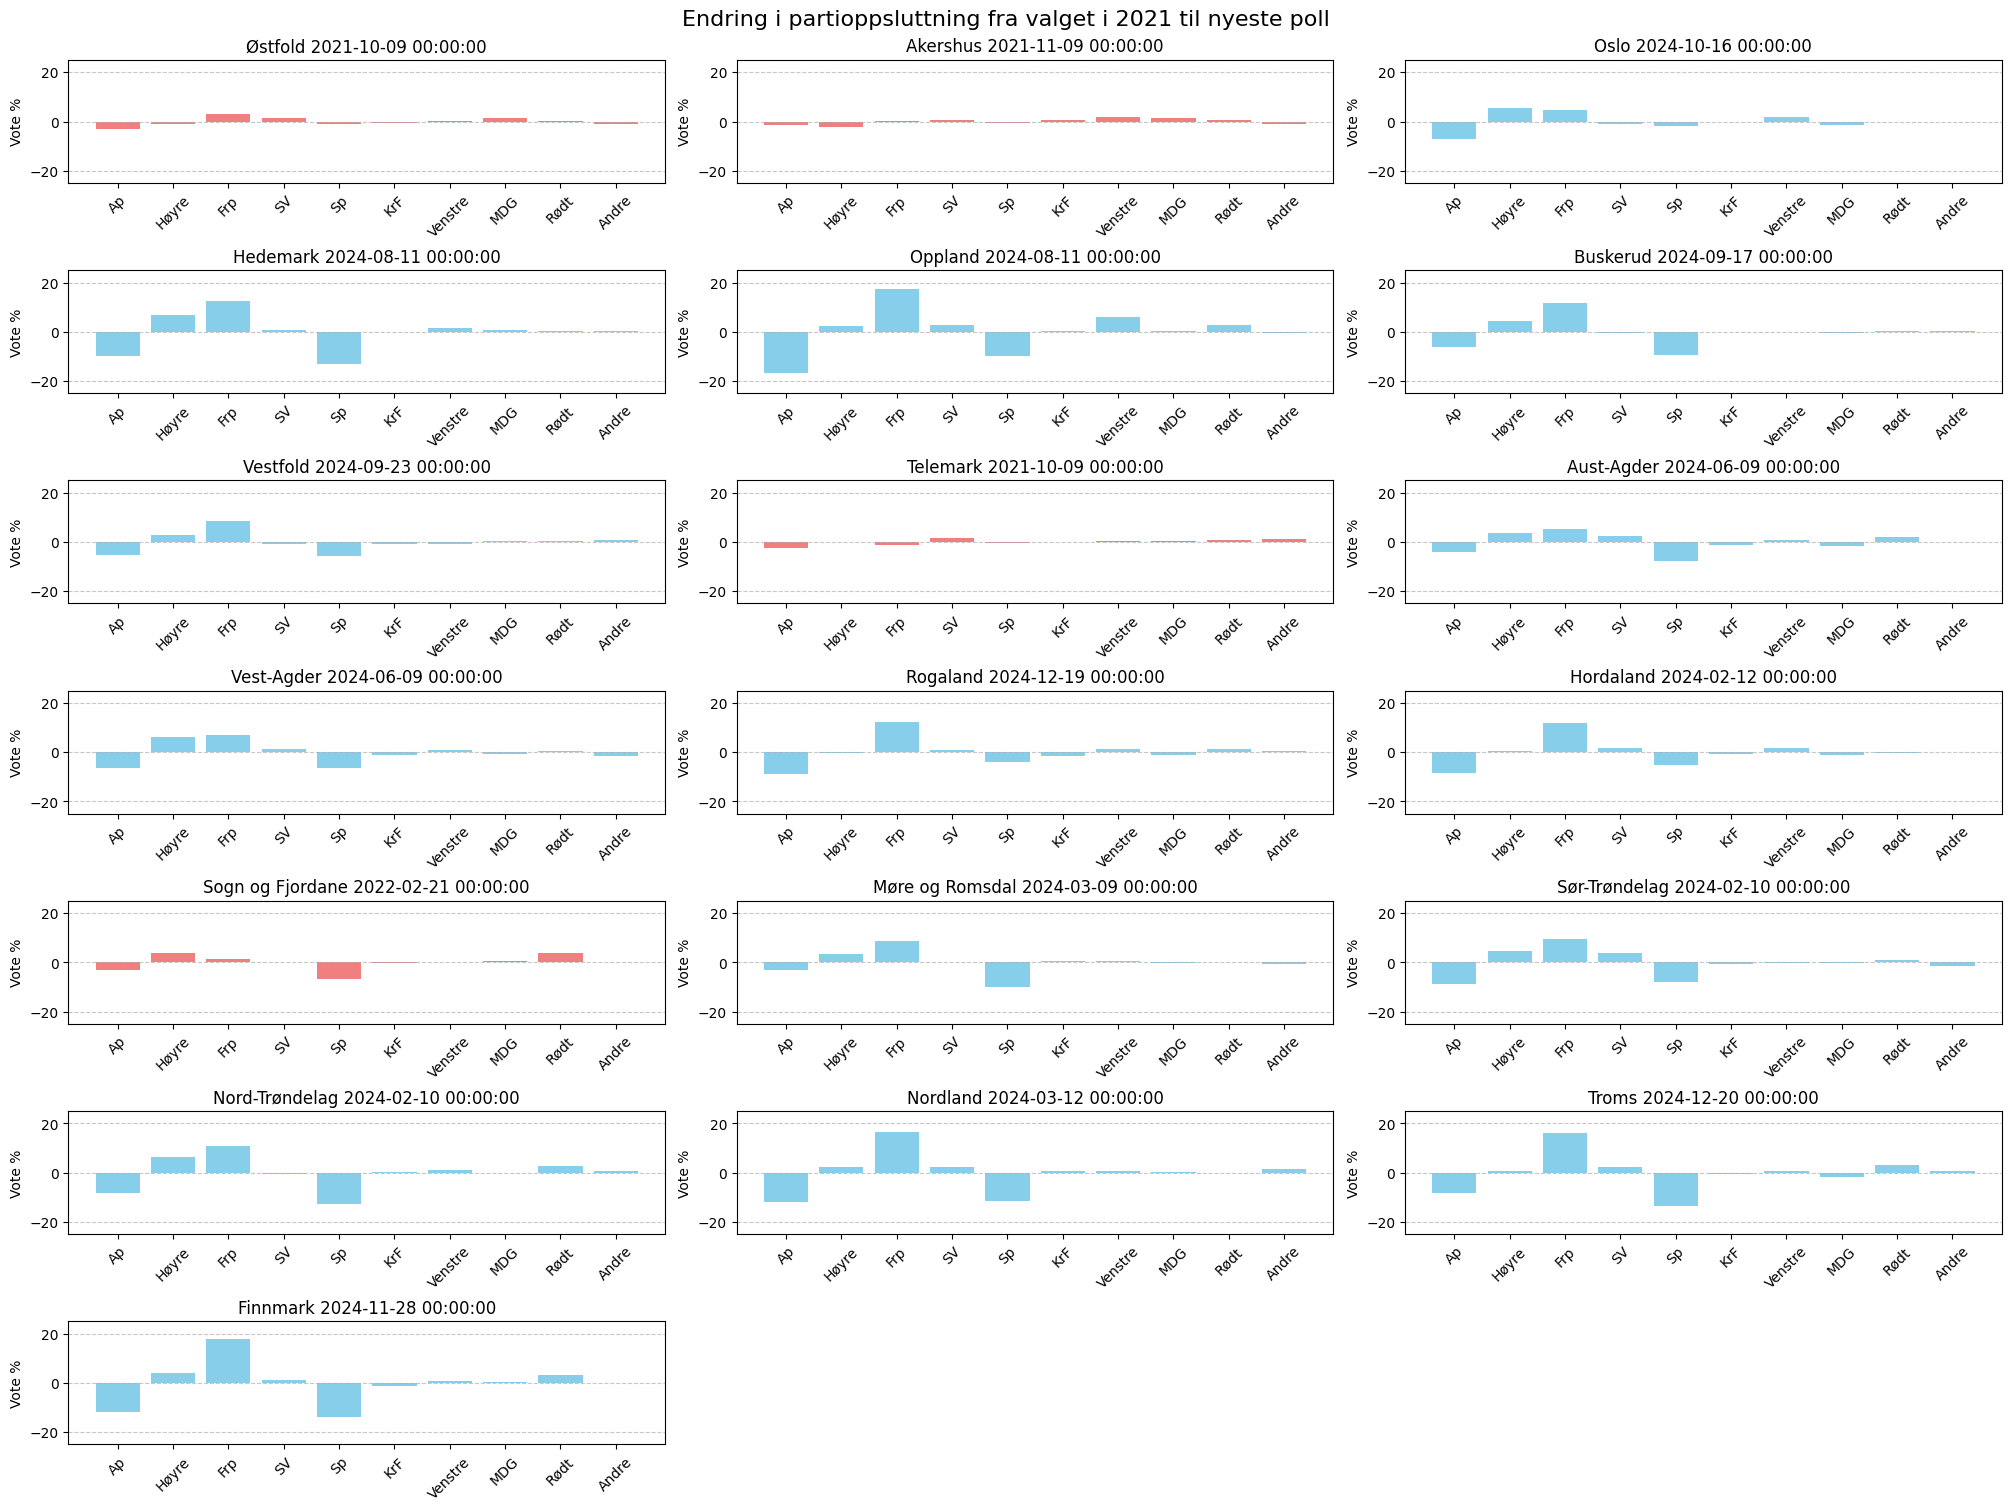

In [335]:
plot_data()

In [336]:
df_election.head(15)

,Valgdistrikt,Partier,Forhånd,Valgting,Stemmer,Endr-sum,Fordeling,Endr-for,Mandat,Endr-Mandat
0,Østfold,Ap,24817.0,24528.0,49345.0,-2200.0,0.305,-1.6,3.0,0.0
1,Østfold,Høyre,15598.0,14613.0,30211.0,-8053.0,0.187,-5.1,2.0,0.0
2,Østfold,Frp,9329.0,11198.0,20527.0,-7654.0,0.127,-4.8,1.0,-1.0
3,Østfold,SV,5525.0,4315.0,9840.0,2804.0,0.061,1.7,1.0,0.0
4,Østfold,Sp,10082.0,12767.0,22849.0,8906.0,0.141,5.4,2.0,1.0
5,Østfold,KrF,2576.0,2838.0,5414.0,-1397.0,0.033,-0.9,0.0,0.0
6,Østfold,Venstre,2408.0,2363.0,4771.0,893.0,0.029,0.5,0.0,0.0
7,Østfold,MDG,2974.0,1808.0,4782.0,590.0,0.030,0.3,0.0,0.0
8,Østfold,Rødt,4258.0,3160.0,7418.0,3983.0,0.046,2.4,0.0,0.0
9,Østfold,Andre,3675.0,3064.0,6739.0,3204.0,0.042,2.0,0.0,0.0


In [337]:
df_joined.head()

,Valgdistrikt,Partier,Fordeling-poll,Poll-dato,Stemmer-valg,Fordeling-valg,Total-stemmer
0,Østfold,Ap,0.275,2021-10-09,49345.0,0.305,161896.0
1,Østfold,Høyre,0.178,2021-10-09,30211.0,0.187,161896.0
2,Østfold,Frp,0.159,2021-10-09,20527.0,0.127,161896.0
3,Østfold,SV,0.077,2021-10-09,9840.0,0.061,161896.0
4,Østfold,Sp,0.129,2021-10-09,22849.0,0.141,161896.0


In [ ]:
def simulate_voting(df,gamma_poll,gamma_election):
    alphas = gamma_election* df['Stemmer-valg'] + gamma_poll* df['Fordeling-poll']*df['Total-stemmer']
    df["alphas"] = alphas
    valgdistrikter = df['Valgdistrikt'].unique()
    fordelings_liste =np.array([])
    for valgdistrikt in valgdistrikter:
        alphavector = df[df["Valgdistrikt"]==valgdistrikt]["alphas"]
        prosent_fordeling = np.random.dirichlet(alphavector)
        fordelings_liste = np.append(fordelings_liste,prosent_fordeling)
    df['Simulert-fordeling'] = fordelings_liste
    df['Simulerte-stemmer'] =df['Simulert-fordeling']*df['Total-stemmer']
    return df

In [ ]:
df_sim = simulate_voting(df_joined,0.5,0.5)
df_sim.head()

,Valgdistrikt,Partier,Fordeling-poll,Poll-dato,Stemmer-valg,Fordeling-valg,Total-stemmer,alphas,Simulert-fordeling,Simulerte-stemmer
0,Østfold,Ap,0.275,2021-10-09,49345.0,0.305,161896.0,46933.200,0.289717,46904.072560
1,Østfold,Høyre,0.178,2021-10-09,30211.0,0.187,161896.0,29514.244,0.182560,29555.719306
2,Østfold,Frp,0.159,2021-10-09,20527.0,0.127,161896.0,23134.232,0.142806,23119.694054
3,Østfold,SV,0.077,2021-10-09,9840.0,0.061,161896.0,11152.996,0.067976,11005.006876
4,Østfold,Sp,0.129,2021-10-09,22849.0,0.141,161896.0,21866.792,0.135249,21896.315802


### Mandate Calculation
In essence the apportionment, consists of the following steps

* For each election district, compute "Direct mandates" using the Modified Sainte-Laguë method (https://no.wikipedia.org/wiki/Sainte-Lagu%C3%ABs_metode) and store the results. In this process a total of 150 mandates (the direct mandates) are apportioned, while the 19 additional mandates (utjevningsmandat) are not included.
* Apply the Modfied Sainte-Laguë method on the national level and apportion all of the 169 mandtes and store the results.
* Find the difference in the number of Mandates for each party on the national level and on the district level. The differnce accounts for which parties should recive the additional mandates(utjevningsmandat)
* Compute the fractions to determine in which districts the parties that should be allotaed additioal mandates should recive them. 

### Utgjevningsmandat kilde

https://www.regjeringen.no/no/dokumenter/nou-2020-6/id2703131/?ch=13#ved7-1

In [340]:
# number of mandates each district must apportion
mandates_per_district = {"Østfold":	9,
"Akershus":	20,
"Oslo":	20,
"Hedemark":	7,
"Oppland":	6,
"Buskerud":	8,
"Vestfold":	7,
"Telemark":	6,
"Aust-Agder":4,
"Vest-Agder":6,
"Rogaland":	14,
"Hordaland":16,
"Sogn og Fjordane":	4,
"Møre og Romsdal":8,
"Sør-Trøndelag":10,
"Nord-Trøndelag":5,
"Nordland":	9,
"Troms":6,
"Finnmark":4}


In [416]:
df_sim.head()

,Valgdistrikt,Partier,Fordeling-poll,Poll-dato,Stemmer-valg,Fordeling-valg,Total-stemmer,alphas,Simulert-fordeling,Simulerte-stemmer
0,Østfold,Ap,0.275,2021-10-09,49345.0,0.305,161896.0,46933.200,0.289717,46904.072560
1,Østfold,Høyre,0.178,2021-10-09,30211.0,0.187,161896.0,29514.244,0.182560,29555.719306
2,Østfold,Frp,0.159,2021-10-09,20527.0,0.127,161896.0,23134.232,0.142806,23119.694054
3,Østfold,SV,0.077,2021-10-09,9840.0,0.061,161896.0,11152.996,0.067976,11005.006876
4,Østfold,Sp,0.129,2021-10-09,22849.0,0.141,161896.0,21866.792,0.135249,21896.315802


In [ ]:
df_sim.groupby("Partier",sort=False)["Simulerte-stemmer"].sum().values

Partier
Ap         681669.750564
Høyre      642106.500225
Frp        469850.643907
SV         241176.756276
Sp         315612.386473
KrF        108471.854957
Venstre    154329.352599
MDG        114611.882961
Rødt       151990.599075
Andre      104367.272964
Name: Simulerte-stemmer, dtype: float64

In [498]:
def district_mandate_calculation(df):
    #Function to apportion the 160 direct mandates, the 19 Leveling seats (utjevningsmandat) are excluded from this apportionment.
    # Each election district has a predetermined number of direct mandates to apportion, in this function we use the Modifed Sainte-Laguës method
    # to compute these in each election district.
    valgdistrikter = df['Valgdistrikt'].unique()
    partier = df['Partier'].unique()
    df_mandate_computation = df[['Valgdistrikt','Partier','Simulerte-stemmer']].copy()
    df_mandate_computation[1.4] = df_mandate_computation["Simulerte-stemmer"]/1.4
    divisor = 3
    for _ in range(20): #greatest number of mandates
        df_mandate_computation[divisor] =df_mandate_computation["Simulerte-stemmer"]/divisor
        divisor = divisor +2
    reference_df = pd.DataFrame({"Partier": partier})
    reference_df["Direkte-mandater"] = np.zeros(10)
    reference_df["Stemmer-nasjonalt"] = df_sim.groupby("Partier",sort=False)["Simulerte-stemmer"].sum().values
    for valgdistrikt in valgdistrikter:
        max_mandates = mandates_per_district[valgdistrikt]-1 #removing extra utjevningsmandat
        df_valgdistrikt = df_mandate_computation[df_mandate_computation["Valgdistrikt"]==valgdistrikt].copy()
        df_temp=pd.melt(df_valgdistrikt, id_vars=['Partier'], value_vars=[1.4,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41])
        df_temp=df_temp.sort_values(['value'],ascending=[False])
        df_temp=df_temp.head(max_mandates)
        partier_counts = df_temp["Partier"].value_counts().reset_index().rename(columns={'count':valgdistrikt})
        reference_df=reference_df.merge(partier_counts, on="Partier", how="left").fillna(0)
    reference_df["Direkte-mandater"] = reference_df.drop(columns=["Partier","Direkte-mandater","Stemmer-nasjonalt"]).sum(axis=1)
    return reference_df

In [499]:
df_mandates_per_district = district_mandate_calculation(df_sim)
df_mandates_per_district

,Partier,Direkte-mandater,Stemmer-nasjonalt,Østfold,Akershus,Oslo,Hedemark,Oppland,Buskerud,Vestfold,...,Vest-Agder,Rogaland,Hordaland,Sogn og Fjordane,Møre og Romsdal,Sør-Trøndelag,Nord-Trøndelag,Nordland,Troms,Finnmark
0,Ap,42.0,681669.750564,3.0,5.0,4.0,2.0,2.0,2.0,2.0,...,1.0,3.0,3.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0
1,Høyre,39.0,642106.500225,2.0,5.0,5.0,1.0,1.0,2.0,2.0,...,2.0,4.0,4.0,1.0,2.0,2.0,1.0,2.0,1.0,0.0
2,Frp,28.0,469850.643907,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,1.0,3.0,3.0,0.0,2.0,2.0,0.0,2.0,1.0,1.0
3,SV,9.0,241176.756276,1.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,Sp,16.0,315612.386473,1.0,2.0,0.0,2.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,KrF,3.0,108471.854957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Venstre,5.0,154329.352599,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,MDG,3.0,114611.882961,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Rødt,4.0,151990.599075,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Andre,1.0,104367.272964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [507]:
def utjevnings_mandate_calculation(df_district_mandates):
    #Takes in the district_mandate_calculation df, specifically the Direct mandates per party and total votes per party
    #Returns df of levelingseats (utjevningsmandat), direct mandates and the total.
    partier = df_district_mandates['Partier'].unique() # list containing all the parties, and from which we will elimnate
    df_national_mandates= pd.DataFrame({"Partier":partier})
    df_national_mandates["Stemmer-nasjonalt"] =df_district_mandates["Stemmer-nasjonalt"]     
    totalt_antall_stemmer = df_national_mandates["Stemmer-nasjonalt"].sum()
    df_national_mandates["Nasjonal-oppsluttning"] = (1/totalt_antall_stemmer)*df_national_mandates["Stemmer-nasjonalt"]
    df_national_mandates["Nasjonale-mandater"] = np.zeros(10)
    df_national_mandates["Direkte-mandater"] =df_district_mandates["Direkte-mandater"]
    df_national_mandates["Utjevnings-mandater"] = np.zeros(10)

    #fjern partier under sperregrensen
    indicies=df_national_mandates.index[df_national_mandates["Nasjonal-oppsluttning"]<0.04].tolist()
    parties_removed = df_national_mandates.iloc[indicies]["Partier"].values.tolist()
    parties_remaining = [x for x in partier if x not in parties_removed]
    mandates_to_remove=df_national_mandates[df_national_mandates["Partier"].isin(parties_removed)]["Direkte-mandater"].sum()
    mandates_to_distribute = int(169 - mandates_to_remove)
    df_national_mandates = df_national_mandates[df_national_mandates["Partier"].isin(parties_remaining)]
    
    # Sainte Lagues
    df_national_mandates[1.4] = df_national_mandates['Stemmer-nasjonalt']/1.4
    divisor = 3
    max_mandates = 50 
    for _ in range(max_mandates): #greatest number of mandates
        df_national_mandates[divisor] =df_national_mandates['Stemmer-nasjonalt']/divisor
        divisor = divisor +2
    liste = [2*i+1 for i in range(max_mandates)]
    liste[0]=1.4

    # list opp partier etter høyeste kvotienter
    df_stacked = pd.melt(df_national_mandates, id_vars=['Partier'], value_vars=liste)
    df_stacked = df_stacked[df_stacked["Partier"].isin(parties_remaining)]
    df_stacked = df_stacked.sort_values(['value'],ascending=[False])
    df_stacked = df_stacked.reset_index(drop=True)

    df_national_mandates.set_index("Partier", inplace=True) # index df... after Parties
    update_series = df_stacked.head(mandates_to_distribute)["Partier"].value_counts() # count. also indexed by parties.
    df_national_mandates["Nasjonale-mandater"].update(update_series) # use update
    df_national_mandates.reset_index(inplace=True) # set the index back to normal
    df_national_mandates["Utjevnings-mandater"] = df_national_mandates["Nasjonale-mandater"]- df_national_mandates["Direkte-mandater"] #regn utjenvingsmandat
    negative_diff=(df_national_mandates["Utjevnings-mandater"] < 0).any().any() # sjekk om noen har negative utjevningsmandater, da skal partiet elimineres fra nomineringen.

    while negative_diff:
        indicies=df_national_mandates.index[df_national_mandates["Utjevnings-mandater"]< 0].tolist() # find indicies of negative utjevningsmandat
        mandates_to_remove = df_national_mandates.iloc[indicies]["Direkte-mandater"].values.sum() #find how many mandtes we must remove 
        new_parties_to_remove = df_national_mandates.iloc[indicies]["Partier"].values.tolist() # 
        
        parties_removed.extend(new_parties_to_remove) # add elements of one list to another
        parties_remaining = [x for x in partier if x not in parties_removed]
        mandates_to_distribute = mandates_to_distribute - mandates_to_remove 
        df_national_mandates = df_national_mandates[df_national_mandates["Partier"].isin(parties_remaining)]

        df_stacked = pd.melt(df_national_mandates, id_vars=['Partier'], value_vars=liste)
        df_stacked = df_stacked[df_stacked["Partier"].isin(parties_remaining)]
        df_stacked = df_stacked.sort_values(['value'],ascending=[False])
        df_stacked = df_stacked.reset_index(drop=True)

        df_national_mandates.set_index("Partier", inplace=True) # index df... after Parties
        update_series = df_stacked.head(mandates_to_distribute)["Partier"].value_counts() # count. also indexed by parties.
        df_national_mandates["Nasjonale-mandater"].update(update_series) # use update
        df_national_mandates.reset_index(inplace=True) # set the index back to normal
        df_national_mandates["Utjevnings-mandater"] = df_national_mandates["Nasjonale-mandater"]- df_national_mandates["Direkte-mandater"]
        negative_diff=(df_national_mandates["Utjevnings-mandater"] < 0).any().any()
    
    #prepare output data
    df_national_mandates=df_national_mandates[["Partier","Utjevnings-mandater"]]
    df_result = pd.DataFrame({"Partier":df_district_mandates["Partier"], "Direkte-mandater":df_district_mandates["Direkte-mandater"]})
    df_result = df_result.merge(df_national_mandates, on="Partier", how="left")
    df_result["Utjevnings-mandater"] = df_result["Utjevnings-mandater"].fillna(0)
    df_result["Total-mandater"] = df_result["Utjevnings-mandater"] + df_result["Direkte-mandater"]

    
    return df_result

Data from 2017 and 2021 election to validate leveling seat (utjevningsmandat) calculation

In [521]:
partier = np.array(['Ap', 'Høyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rødt', 'Andre'])
mandater_2021 =np.array([48,35,17,8,28,3,3,3,4,1])
stemmer_2021 = np.array([783394,607316,346474,228063,402961,113344,137433,117647,140931,106624])
df_valg_2021 = pd.DataFrame({"Partier": partier, "Direkte-mandater":mandater_2021, "Stemmer-nasjonalt":stemmer_2021})
stemmer_2017 = np.array([800949,732897,444683,176222,302017,122797,127911,94788,70522,54057])
mandater_2017 = np.array([50,44,26,5,16,3,3,2,1,0])
df_valg_2017 = pd.DataFrame({"Partier": partier, "Direkte-mandater":mandater_2017, "Stemmer-nasjonalt":stemmer_2017})

In [524]:
validate_2021=utjevnings_mandate_calculation(df_valg_2021)
validate_2021

,Partier,Direkte-mandater,Utjevnings-mandater,Total-mandater
0,Ap,48,0.0,48.0
1,Høyre,35,1.0,36.0
2,Frp,17,4.0,21.0
3,SV,8,5.0,13.0
4,Sp,28,0.0,28.0
5,KrF,3,0.0,3.0
6,Venstre,3,5.0,8.0
7,MDG,3,0.0,3.0
8,Rødt,4,4.0,8.0
9,Andre,1,0.0,1.0


### Load Election district Population and Mandate distribution

In [ ]:
col_names = ["Valgdistrikt","Mandater","Befolkningstall"]
df = pd.read_csv('./data/mandate-distribution.csv',header=None,names=col_names) 
df 

,Valgdistrikt,Mandater,Befolkningstall
0,Østfold,9,312152
1,Akershus,20,728803
2,Oslo,20,717710
3,Hedemark,7,202048
4,Oppland,6,174256
5,Buskerud,8,269819
6,Vestfold,7,256432
7,Telemark,6,177093
8,Aust-Agder,4,122968
9,Vest-Agder,6,196882


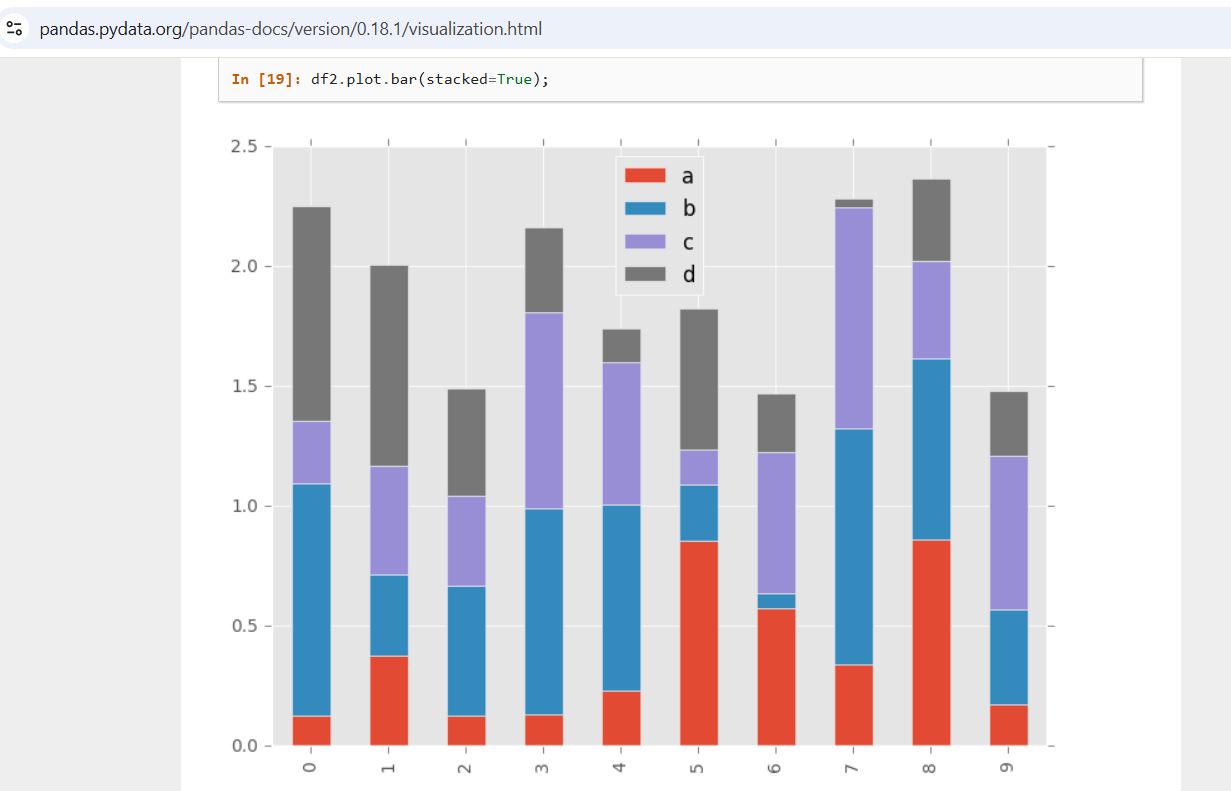

### Idea of the simulation

$$ Dir(\alpha) + Polling + \gamma = Dir(\bar{\alpha})$$

For each election district, we compute set a vector $\alpha$ of length 8 (number of parties). The ith element of the parameter belonging to the $k$ th election district $\alpha_i^k$ is computed as
$$

\alpha_i^k = \gamma_{\text{Valg}} n_i^k p_i^k +  \gamma_{\text{Poll}} m_i^k b_i^k + 1

$$
$n_i^k$ denotes the number of votes for political party $i$ in election district $k$, $p_i^k$ denotes the fraction of votes for the party in the election, $m_i^k$ denotes the number of votes for the party in the polling and b_i^k$ denotes the fraction of votes for the party in the polls. 

